In [1]:
from __future__ import print_function

import argparse
import csv
import os
import sys
import tifffile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import glob
import pickle

import datetime
import math
import json
import time

import timm
from timm.models import create_model
from timm.scheduler import CosineLRScheduler
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict

from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import torchvision.transforms as T
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler

from customloss import CustomLoss
from datamgr import *
import utils
from engine import *
from dataset import *
from models import *
from samplers import RASampler

import copy
from pathlib import Path
from tqdm import tqdm
%matplotlib inline

In [2]:
def parse_args():
    parser = argparse.ArgumentParser(description= 'CBNA training script')
    parser.add_argument('--model_type'       , default='CNN', help='CNN/MLP/ViT/Fusion')
    parser.add_argument('--data_set'     , default='CBNA')
    parser.add_argument('--data_path'     , default='Data/irc_patches/')
    parser.add_argument('--file_path'     , default='datafile/')
    parser.add_argument('--output_dir', default='checkpoints/', help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cpu', help='device to use for training / testing')
    parser.add_argument('--batch_size', default=128, type=int, help='Per-GPU batch-size : number of distinct images loaded on one GPU.')
    parser.add_argument('--input_size'  , default=224, type=int, help ='Image size for training')
    parser.add_argument('--drop_path'   , type=float, default=0.05)
    parser.add_argument('--eval_crop_ratio', default=0.875, type=float, help="Crop ratio for evaluation")
    parser.add_argument('--num_workers', default=8, type=int, help='Number of data loading workers per GPU.')
    parser.add_argument('--seed'       , default=0, type=int, help='seed')

    return parser.parse_args('')

args = parse_args()
output_dir = Path(args.output_dir).joinpath('{}/{}/'.format(args.data_set, args.model_type))
args.output_dir = output_dir
if not os.path.isdir(args.output_dir):
    try:
        os.makedirs(args.output_dir, exist_ok = True)
        print("Directory '%s' created successfully" %args.output_dir)
    except OSError as error:
        print("Directory '%s' can not be created")

if args.data_set == 'CBNA':
    args.classes = list(np.genfromtxt(Path(args.file_path).joinpath('classes.txt'), dtype='str'))
    args.num_classes = len(args.classes)
    print('number of labels: ', args.num_classes)

number of labels:  2522


In [4]:
utils.fix_random_seeds(args.seed)
cudnn.benchmark = True
num_tasks = utils.get_world_size()
global_rank = utils.get_rank()

dataset_test = build_dataset(args, is_train=False)
args.test_label_cnt = dataset_test.get_label_count()
print(f"Data loaded: there are {len(dataset_test)} test images.")
sampler_test = torch.utils.data.SequentialSampler(dataset_test)
test_loader = DataLoader(dataset_test, sampler=sampler_test, batch_size=args.batch_size, num_workers=args.num_workers, pin_memory=True, drop_last=False)

Data loaded: there are 15980 test images.


In [6]:
model = Resnet_CBNA(args, out_dim=args.num_classes)
model.to(args.device)

reload_file = utils.get_best_file(args.output_dir)        
print("best_file" , reload_file)

checkpoint = torch.load(reload_file, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.eval()
print("model loaded")

best_file checkpoints/CBNA/CNN/best.pth
model loaded


125295.0,96534.0,88459.0,88510.0,115470.0,96465.0,87540.0,98586.0,108718.0,128394.0,134346.0,88752.0,112426.0,96852.0,108027.0


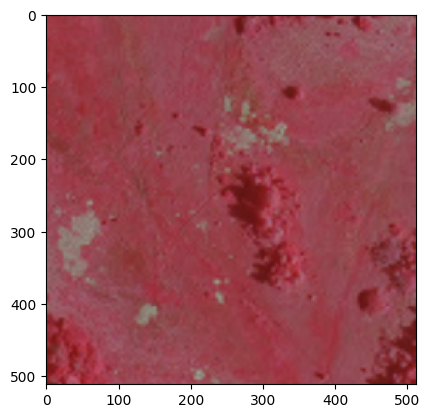

In [15]:
idx = 7
image, target = dataset_test[idx]
img = dataset_test.show_sample(idx)
image = image.to(args.device)
target = target.to(args.device)
with torch.no_grad():
    preds = torch.sigmoid(model(image.unsqueeze(0)))

In [16]:
target_ind = target.nonzero().flatten().cpu()
target_preds = preds[0][target_ind].cpu()
target_ind = target_ind.tolist()

In [17]:
class Hook():
    def __init__(self, model):
        self.hook = model.register_forward_hook(self.hook_func, prepend=False)   
    def hook_func(self, model, input, output): self.stored = output.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()
        
class HookBwd():
    def __init__(self, model):
        self.hook = model.register_full_backward_hook(self.hook_func, prepend=False)
    def hook_func(self, model, grad_input, grad_output): self.stored = grad_output[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [18]:
grads = []

for cls_idx in target_ind:
    print('class index: ', cls_idx)
    with HookBwd(model.base_model.layer4) as hookb:
        with Hook(model.base_model.layer4) as hookf:
            output = model(image.unsqueeze(0))
            act = hookf.stored

        output[0,cls_idx].backward()
        grads.append(hookb.stored)

cam_maps = {}
j = 0
for i in target_ind:
    w = grads[j][0].mean(dim=[1,2], keepdim = True)
    cam_maps[i] = F.relu((w*act[0]).sum(0))
    j += 1

class index:  363
class index:  383
class index:  505
class index:  649
class index:  1009
class index:  1124
class index:  1292
class index:  1907
class index:  1964
class index:  1978
class index:  2005
class index:  2317
class index:  2323
class index:  2342
class index:  2423


cd_ref:  [108027.0, 108718.0, 112426.0, 115470.0, 125295.0, 128394.0, 134346.0, 87540.0, 88459.0, 88510.0, 88752.0, 96465.0, 96534.0, 96852.0, 98586.0]
species:  ['Mentha aquatica L., 1753', 'Molinia caerulea (L.) Moench, 1794', 'Parnassia palustris L., 1753', 'Potentilla erecta (L.) Raeusch., 1797', 'Succisa pratensis Moench, 1794', 'Valeriana dioica L., 1753', 'Eupatorium cannabinum subsp. cannabinum L., 1753', 'Caltha palustris L., 1753', 'Carex davalliana Sm., 1800', 'Carex flacca Schreb., 1771', 'Carex panicea L., 1753', 'Epipactis palustris (L.) Crantz, 1769', 'Equisetum palustre L., 1753', 'Eriophorum latifolium Hoppe, 1800', 'Festuca trichophylla (Ducros ex Gaudin) K.Richt., 1890']


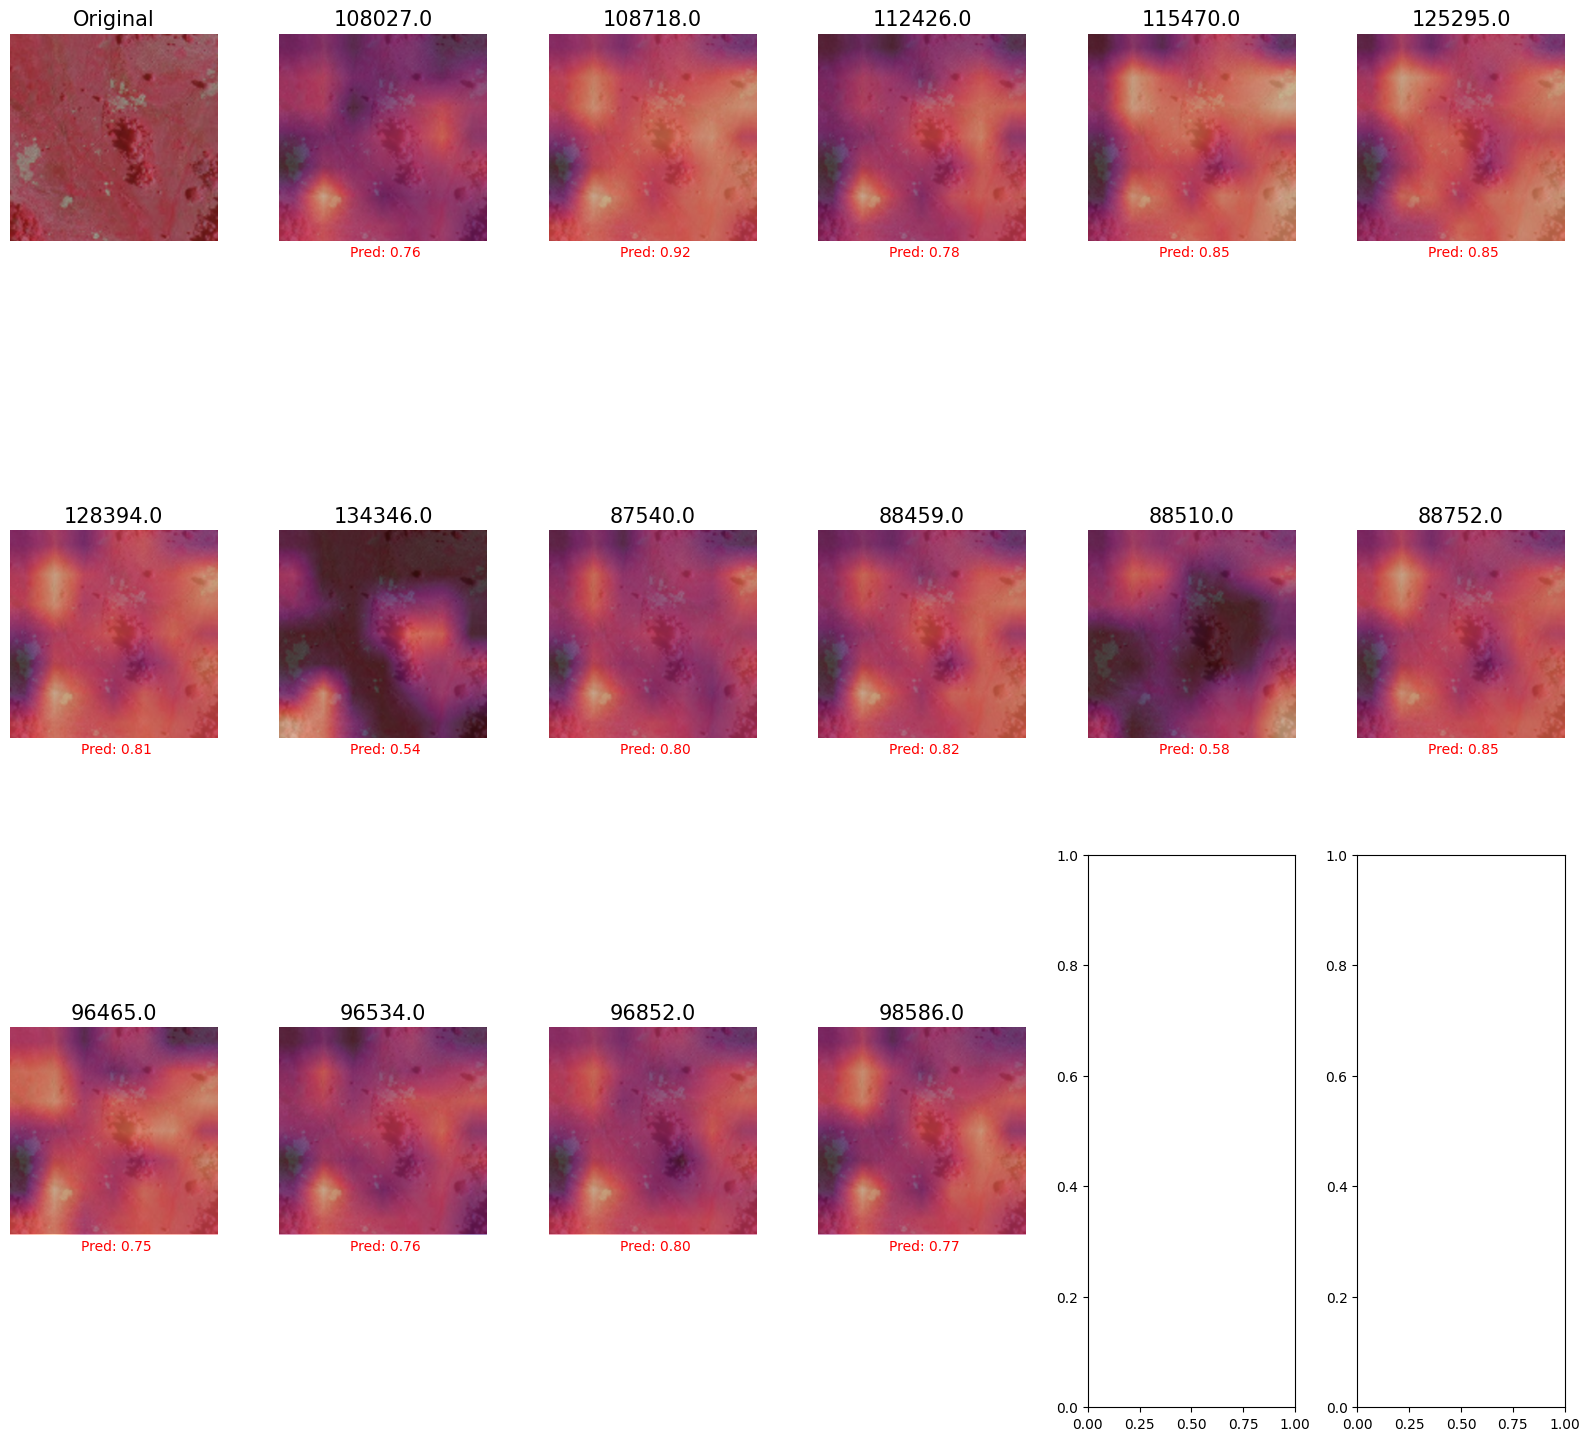

In [19]:
cd_ref = list(map(float, dataset_test.decode(target, threshold=0.45).split(',')))
print('cd_ref: ', cd_ref)
#print('cd_ref_pred: ', list(map(float, dataset_test.decode(preds[0], threshold=0.6).split(','))))

cdref2species = pd.read_csv('filelist/cdref2species.csv')
species = []
for ref in cd_ref:
    temp = cdref2species.loc[cdref2species.cd_ref==ref]
    species.append(temp.nom_reconnu.values[0])

print('species: ', species)

width = 6
fig, ax = plt.subplots(math.ceil((len(target_ind)+1) / width), width, figsize = (16,16))
for i, ind in enumerate(target_ind, start = 1):
    ax.ravel()[i].axis('off')
    ax.ravel()[i].imshow(img)
    ax.ravel()[i].imshow(cam_maps[ind].detach().cpu(), alpha = 0.5, extent = (0,512,512,0), interpolation = 'bilinear', cmap = 'magma')
    ax.ravel()[i].set_title(args.classes[ind], size = 15)
    ax.ravel()[i].text(175, 550, 'Pred: ' + str("{:.2f}".format(target_preds[i-1].item())), color = 'red', size = 10)

ax.ravel()[0].axis('off')
ax.ravel()[0].imshow(img)
ax.ravel()[0].set_title('Original', size = 15)
#fig.suptitle('Activation maps', fontsize = 20)
fig.tight_layout()